In [1]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import UnetPlus
from ImageLoader import ImageLoader2D

In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "UnetPlus"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [4]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  7.27it/s]


In [5]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [6]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [7]:
# Creating the model

model = UnetPlus.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [8]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [9]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
8/8 [==============================] - 31s 704ms/step - loss: 0.7547 - val_loss: 0.8113
Loss Validation: 0.8113388
Loss Test: 0.7793721
Saved model with val_loss:  0.8113388


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 1
Learning Rate: 0.0001
8/8 [==============================] - 5s 557ms/step - loss: 0.7311 - val_loss: 0.8079
Loss Validation: 0.8079041
Loss Test: 0.7750411
Saved model with val_loss:  0.8079041


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 2
Learning Rate: 0.0001
8/8 [==============================] - 5s 603ms/step - loss: 0.6949 - val_loss: 0.8069
Loss Validation: 0.806917
Loss Test: 0.77378786
Saved model with val_loss:  0.806917


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 3
Learning Rate: 0.0001
8/8 [==============================] - 4s 519ms/step - loss: 0.6909 - val_loss: 0.8089
Loss Validation: 0.8089339
Loss Test: 0.7739337
Training, epoch 4
Learning Rate: 0.0001
8/8 [==============================] - 4s 566ms/step - loss: 0.6680 - val_loss: 0.8106
Loss Validation: 0.81060445
Loss Test: 0.7749032
Training, epoch 5
Learning Rate: 0.0001
8/8 [==============================] - 4s 534ms/step - loss: 0.6767 - val_loss: 0.8157
Loss Validation: 0.8156622
Loss Test: 0.7806502
Training, epoch 6
Learning Rate: 0.0001
8/8 [==============================] - 5s 626ms/step - loss: 0.6537 - val_loss: 0.8178
Loss Validation: 0.8177761
Loss Test: 0.7832257
Training, epoch 7
Learning Rate: 0.0001
8/8 [==============================] - 5s 614ms/step - loss: 0.6574 - val_loss: 0.8228
Loss Validation: 0.822772
Loss Test: 0.79026306
Training, epoch 8
Learning Rate: 0.0001
8/8 [==============================] - 5s 608ms/step - loss: 0.6404 - val_loss: 0.83

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 37
Learning Rate: 0.0001
8/8 [==============================] - 5s 586ms/step - loss: 0.5179 - val_loss: 0.8969
Loss Validation: 0.8968711
Loss Test: 0.70910275
Training, epoch 38
Learning Rate: 0.0001
8/8 [==============================] - 5s 636ms/step - loss: 0.5543 - val_loss: 0.9299
Loss Validation: 0.92989415
Loss Test: 0.7673915
Training, epoch 39
Learning Rate: 0.0001
8/8 [==============================] - 4s 506ms/step - loss: 0.5242 - val_loss: 0.8888
Loss Validation: 0.88876724
Loss Test: 0.5920026
Training, epoch 40
Learning Rate: 0.0001
8/8 [==============================] - 4s 555ms/step - loss: 0.5122 - val_loss: 0.6199
Loss Validation: 0.6199467
Loss Test: 0.37388444
Saved model with val_loss:  0.6199467


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 41
Learning Rate: 0.0001
8/8 [==============================] - 5s 622ms/step - loss: 0.4998 - val_loss: 0.7163
Loss Validation: 0.7163329
Loss Test: 0.42345148
Training, epoch 42
Learning Rate: 0.0001
8/8 [==============================] - 5s 646ms/step - loss: 0.4884 - val_loss: 0.6261
Loss Validation: 0.62609553
Loss Test: 0.3787619
Training, epoch 43
Learning Rate: 0.0001
8/8 [==============================] - 5s 606ms/step - loss: 0.4999 - val_loss: 0.7970
Loss Validation: 0.7969527
Loss Test: 0.60071373
Training, epoch 44
Learning Rate: 0.0001
8/8 [==============================] - 4s 545ms/step - loss: 0.4890 - val_loss: 0.6825
Loss Validation: 0.6824529
Loss Test: 0.46941835
Training, epoch 45
Learning Rate: 0.0001
8/8 [==============================] - 5s 570ms/step - loss: 0.5011 - val_loss: 0.6456
Loss Validation: 0.64558995
Loss Test: 0.3714074
Training, epoch 46
Learning Rate: 0.0001
8/8 [==============================] - 5s 689ms/step - loss: 0.4669 - val_

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 49
Learning Rate: 0.0001
8/8 [==============================] - 5s 605ms/step - loss: 0.5150 - val_loss: 0.5275
Loss Validation: 0.52752614
Loss Test: 0.34212595
Saved model with val_loss:  0.52752614


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 50
Learning Rate: 0.0001
8/8 [==============================] - 5s 658ms/step - loss: 0.4776 - val_loss: 0.5520
Loss Validation: 0.5519743
Loss Test: 0.344128
Training, epoch 51
Learning Rate: 0.0001
8/8 [==============================] - 5s 607ms/step - loss: 0.4687 - val_loss: 0.5811
Loss Validation: 0.5811217
Loss Test: 0.3739516
Training, epoch 52
Learning Rate: 0.0001
8/8 [==============================] - 5s 620ms/step - loss: 0.4569 - val_loss: 0.6089
Loss Validation: 0.60885924
Loss Test: 0.49455798
Training, epoch 53
Learning Rate: 0.0001
8/8 [==============================] - 5s 691ms/step - loss: 0.4552 - val_loss: 0.5807
Loss Validation: 0.5807259
Loss Test: 0.31247854
Training, epoch 54
Learning Rate: 0.0001
8/8 [==============================] - 5s 653ms/step - loss: 0.4840 - val_loss: 0.5629
Loss Validation: 0.56285954
Loss Test: 0.36637563
Training, epoch 55
Learning Rate: 0.0001
8/8 [==============================] - 5s 552ms/step - loss: 0.5107 - val_l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 69
Learning Rate: 0.0001
8/8 [==============================] - 5s 618ms/step - loss: 0.4992 - val_loss: 0.5816
Loss Validation: 0.5815545
Loss Test: 0.28958124
Training, epoch 70
Learning Rate: 0.0001
8/8 [==============================] - 5s 622ms/step - loss: 0.4566 - val_loss: 0.5556
Loss Validation: 0.5555644
Loss Test: 0.30532366
Training, epoch 71
Learning Rate: 0.0001
8/8 [==============================] - 5s 561ms/step - loss: 0.4428 - val_loss: 0.5547
Loss Validation: 0.554675
Loss Test: 0.30256438
Training, epoch 72
Learning Rate: 0.0001
8/8 [==============================] - 5s 657ms/step - loss: 0.4854 - val_loss: 0.5336
Loss Validation: 0.5335838
Loss Test: 0.2857455
Training, epoch 73
Learning Rate: 0.0001
8/8 [==============================] - 5s 556ms/step - loss: 0.4742 - val_loss: 0.5356
Loss Validation: 0.53560275
Loss Test: 0.3043238
Training, epoch 74
Learning Rate: 0.0001
8/8 [==============================] - 4s 556ms/step - loss: 0.4119 - val_lo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 85
Learning Rate: 0.0001
8/8 [==============================] - 5s 533ms/step - loss: 0.4144 - val_loss: 0.5536
Loss Validation: 0.55358213
Loss Test: 0.26581806
Training, epoch 86
Learning Rate: 0.0001
8/8 [==============================] - 5s 587ms/step - loss: 0.3977 - val_loss: 0.6436
Loss Validation: 0.6436458
Loss Test: 0.2300905
Training, epoch 87
Learning Rate: 0.0001
8/8 [==============================] - 5s 613ms/step - loss: 0.4248 - val_loss: 0.5463
Loss Validation: 0.5462707
Loss Test: 0.27336442
Training, epoch 88
Learning Rate: 0.0001
8/8 [==============================] - 5s 615ms/step - loss: 0.4220 - val_loss: 0.4948
Loss Validation: 0.49477917
Loss Test: 0.26633728
Saved model with val_loss:  0.49477917


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 89
Learning Rate: 0.0001
8/8 [==============================] - 5s 635ms/step - loss: 0.4327 - val_loss: 0.5813
Loss Validation: 0.58131135
Loss Test: 0.24588042
Training, epoch 90
Learning Rate: 0.0001
8/8 [==============================] - 4s 478ms/step - loss: 0.4511 - val_loss: 0.5255
Loss Validation: 0.52548885
Loss Test: 0.32872993
Training, epoch 91
Learning Rate: 0.0001
8/8 [==============================] - 5s 594ms/step - loss: 0.4367 - val_loss: 0.5177
Loss Validation: 0.51774436
Loss Test: 0.24844545
Training, epoch 92
Learning Rate: 0.0001
8/8 [==============================] - 5s 680ms/step - loss: 0.4533 - val_loss: 0.4990
Loss Validation: 0.49902254
Loss Test: 0.24997985
Training, epoch 93
Learning Rate: 0.0001
8/8 [==============================] - 6s 754ms/step - loss: 0.4735 - val_loss: 0.4678
Loss Validation: 0.46777117
Loss Test: 0.2750299
Saved model with val_loss:  0.46777117


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 94
Learning Rate: 0.0001
8/8 [==============================] - 5s 529ms/step - loss: 0.4210 - val_loss: 0.5960
Loss Validation: 0.5959723
Loss Test: 0.26113027
Training, epoch 95
Learning Rate: 0.0001
8/8 [==============================] - 5s 704ms/step - loss: 0.4949 - val_loss: 0.4678
Loss Validation: 0.46783084
Loss Test: 0.27488548
Training, epoch 96
Learning Rate: 0.0001
8/8 [==============================] - 4s 562ms/step - loss: 0.4179 - val_loss: 0.3761
Loss Validation: 0.37608224
Loss Test: 0.26981956
Saved model with val_loss:  0.37608224


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 97
Learning Rate: 0.0001
8/8 [==============================] - 5s 588ms/step - loss: 0.4246 - val_loss: 0.4932
Loss Validation: 0.49322516
Loss Test: 0.27487844
Training, epoch 98
Learning Rate: 0.0001
8/8 [==============================] - 4s 546ms/step - loss: 0.3988 - val_loss: 0.5408
Loss Validation: 0.5408385
Loss Test: 0.2572686
Training, epoch 99
Learning Rate: 0.0001
8/8 [==============================] - 5s 615ms/step - loss: 0.4505 - val_loss: 0.5170
Loss Validation: 0.5170122
Loss Test: 0.24578363
Training, epoch 100
Learning Rate: 0.0001
8/8 [==============================] - 5s 587ms/step - loss: 0.4281 - val_loss: 0.5711
Loss Validation: 0.5711428
Loss Test: 0.2766049
Training, epoch 101
Learning Rate: 0.0001
8/8 [==============================] - 4s 535ms/step - loss: 0.4248 - val_loss: 0.5316
Loss Validation: 0.53163934
Loss Test: 0.2821802
Training, epoch 102
Learning Rate: 0.0001
8/8 [==============================] - 4s 576ms/step - loss: 0.4222 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 136
Learning Rate: 0.0001
8/8 [==============================] - 5s 579ms/step - loss: 0.3556 - val_loss: 0.4553
Loss Validation: 0.45528632
Loss Test: 0.22542495
Training, epoch 137
Learning Rate: 0.0001
8/8 [==============================] - 5s 596ms/step - loss: 0.3682 - val_loss: 0.4173
Loss Validation: 0.41731322
Loss Test: 0.22098088
Training, epoch 138
Learning Rate: 0.0001
8/8 [==============================] - 4s 580ms/step - loss: 0.3726 - val_loss: 0.4826
Loss Validation: 0.48264682
Loss Test: 0.23351151
Training, epoch 139
Learning Rate: 0.0001
8/8 [==============================] - 5s 634ms/step - loss: 0.3477 - val_loss: 0.4406
Loss Validation: 0.44059765
Loss Test: 0.20546061
Training, epoch 140
Learning Rate: 0.0001
8/8 [==============================] - 5s 599ms/step - loss: 0.3548 - val_loss: 0.4073
Loss Validation: 0.4072913
Loss Test: 0.20780581
Training, epoch 141
Learning Rate: 0.0001
8/8 [==============================] - 5s 651ms/step - loss: 0.3

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 143
Learning Rate: 0.0001
8/8 [==============================] - 5s 593ms/step - loss: 0.3400 - val_loss: 0.3730
Loss Validation: 0.37297833
Loss Test: 0.2508756
Training, epoch 144
Learning Rate: 0.0001
8/8 [==============================] - 5s 558ms/step - loss: 0.3610 - val_loss: 0.4717
Loss Validation: 0.47166342
Loss Test: 0.21960998
Training, epoch 145
Learning Rate: 0.0001
8/8 [==============================] - 5s 601ms/step - loss: 0.3490 - val_loss: 0.4199
Loss Validation: 0.4198817
Loss Test: 0.22252572
Training, epoch 146
Learning Rate: 0.0001
8/8 [==============================] - 5s 595ms/step - loss: 0.3899 - val_loss: 0.4667
Loss Validation: 0.466681
Loss Test: 0.2522707
Training, epoch 147
Learning Rate: 0.0001
8/8 [==============================] - 5s 651ms/step - loss: 0.3631 - val_loss: 0.3527
Loss Validation: 0.3526789
Loss Test: 0.24897224
Saved model with val_loss:  0.3526789


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 148
Learning Rate: 0.0001
8/8 [==============================] - 6s 669ms/step - loss: 0.3531 - val_loss: 0.3866
Loss Validation: 0.38661784
Loss Test: 0.24238187
Training, epoch 149
Learning Rate: 0.0001
8/8 [==============================] - 5s 648ms/step - loss: 0.3528 - val_loss: 0.3986
Loss Validation: 0.3986497
Loss Test: 0.2236141
Training, epoch 150
Learning Rate: 0.0001
8/8 [==============================] - 5s 607ms/step - loss: 0.3454 - val_loss: 0.4677
Loss Validation: 0.46766222
Loss Test: 0.30610257
Training, epoch 151
Learning Rate: 0.0001
8/8 [==============================] - 5s 592ms/step - loss: 0.3431 - val_loss: 0.4239
Loss Validation: 0.42385036
Loss Test: 0.26271433
Training, epoch 152
Learning Rate: 0.0001
8/8 [==============================] - 5s 576ms/step - loss: 0.3358 - val_loss: 0.3944
Loss Validation: 0.39438313
Loss Test: 0.23404509
Training, epoch 153
Learning Rate: 0.0001
8/8 [==============================] - 5s 557ms/step - loss: 0.34

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 173
Learning Rate: 0.0001
8/8 [==============================] - 6s 720ms/step - loss: 0.3128 - val_loss: 0.3614
Loss Validation: 0.36143088
Loss Test: 0.18815303
Training, epoch 174
Learning Rate: 0.0001
8/8 [==============================] - 5s 582ms/step - loss: 0.3246 - val_loss: 0.5514
Loss Validation: 0.5513581
Loss Test: 0.2836905
Training, epoch 175
Learning Rate: 0.0001
8/8 [==============================] - 4s 529ms/step - loss: 0.3243 - val_loss: 0.5257
Loss Validation: 0.5256858
Loss Test: 0.23486996
Training, epoch 176
Learning Rate: 0.0001
8/8 [==============================] - 4s 540ms/step - loss: 0.2846 - val_loss: 0.4360
Loss Validation: 0.4359892
Loss Test: 0.19881845
Training, epoch 177
Learning Rate: 0.0001
8/8 [==============================] - 5s 595ms/step - loss: 0.3396 - val_loss: 0.4530
Loss Validation: 0.452951
Loss Test: 0.18682432
Training, epoch 178
Learning Rate: 0.0001
8/8 [==============================] - 5s 613ms/step - loss: 0.3188 -

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 182
Learning Rate: 0.0001
8/8 [==============================] - 5s 592ms/step - loss: 0.3546 - val_loss: 0.4077
Loss Validation: 0.40767616
Loss Test: 0.22235245
Training, epoch 183
Learning Rate: 0.0001
8/8 [==============================] - 5s 612ms/step - loss: 0.3706 - val_loss: 0.3907
Loss Validation: 0.39069402
Loss Test: 0.19301534
Training, epoch 184
Learning Rate: 0.0001
8/8 [==============================] - 5s 652ms/step - loss: 0.3268 - val_loss: 0.3984
Loss Validation: 0.3983901
Loss Test: 0.18614346
Training, epoch 185
Learning Rate: 0.0001
8/8 [==============================] - 5s 616ms/step - loss: 0.3069 - val_loss: 0.3532
Loss Validation: 0.35322338
Loss Test: 0.21169966
Training, epoch 186
Learning Rate: 0.0001
8/8 [==============================] - 4s 561ms/step - loss: 0.2989 - val_loss: 0.4099
Loss Validation: 0.40992236
Loss Test: 0.19457114
Training, epoch 187
Learning Rate: 0.0001
8/8 [==============================] - 4s 493ms/step - loss: 0.3

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 199
Learning Rate: 0.0001
8/8 [==============================] - 5s 636ms/step - loss: 0.3043 - val_loss: 0.3044
Loss Validation: 0.30441564
Loss Test: 0.19056946
Saved model with val_loss:  0.30441564


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 200
Learning Rate: 0.0001
8/8 [==============================] - 4s 493ms/step - loss: 0.3113 - val_loss: 0.4190
Loss Validation: 0.41899842
Loss Test: 0.19504029
Training, epoch 201
Learning Rate: 0.0001
8/8 [==============================] - 6s 688ms/step - loss: 0.3240 - val_loss: 0.3491
Loss Validation: 0.3491279
Loss Test: 0.21743363
Training, epoch 202
Learning Rate: 0.0001
8/8 [==============================] - 5s 587ms/step - loss: 0.3236 - val_loss: 0.3730
Loss Validation: 0.3729599
Loss Test: 0.18389446
Training, epoch 203
Learning Rate: 0.0001
8/8 [==============================] - 4s 580ms/step - loss: 0.3458 - val_loss: 0.3702
Loss Validation: 0.37023318
Loss Test: 0.15933418
Training, epoch 204
Learning Rate: 0.0001
8/8 [==============================] - 5s 634ms/step - loss: 0.2893 - val_loss: 0.3280
Loss Validation: 0.32804167
Loss Test: 0.19377446
Training, epoch 205
Learning Rate: 0.0001
8/8 [==============================] - 5s 575ms/step - loss: 0.31

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 249
Learning Rate: 0.0001
8/8 [==============================] - 5s 597ms/step - loss: 0.2850 - val_loss: 0.3482
Loss Validation: 0.34818876
Loss Test: 0.17121452
Training, epoch 250
Learning Rate: 0.0001
8/8 [==============================] - 4s 500ms/step - loss: 0.2419 - val_loss: 0.4390
Loss Validation: 0.4390425
Loss Test: 0.15805143
Training, epoch 251
Learning Rate: 0.0001
8/8 [==============================] - 5s 598ms/step - loss: 0.2394 - val_loss: 0.3684
Loss Validation: 0.36839682
Loss Test: 0.18279618
Training, epoch 252
Learning Rate: 0.0001
8/8 [==============================] - 4s 516ms/step - loss: 0.2412 - val_loss: 0.3152
Loss Validation: 0.315247
Loss Test: 0.16582191
Training, epoch 253
Learning Rate: 0.0001
8/8 [==============================] - 5s 595ms/step - loss: 0.2441 - val_loss: 0.4825
Loss Validation: 0.4825328
Loss Test: 0.24635369
Training, epoch 254
Learning Rate: 0.0001
8/8 [==============================] - 5s 587ms/step - loss: 0.2478

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 255
Learning Rate: 0.0001
8/8 [==============================] - 5s 586ms/step - loss: 0.2831 - val_loss: 0.4515
Loss Validation: 0.45146298
Loss Test: 0.17179751
Training, epoch 256
Learning Rate: 0.0001
8/8 [==============================] - 4s 455ms/step - loss: 0.2806 - val_loss: 0.3529
Loss Validation: 0.3528661
Loss Test: 0.21666229
Training, epoch 257
Learning Rate: 0.0001
8/8 [==============================] - 5s 675ms/step - loss: 0.2660 - val_loss: 0.3379
Loss Validation: 0.3378576
Loss Test: 0.1757589
Training, epoch 258
Learning Rate: 0.0001
8/8 [==============================] - 5s 600ms/step - loss: 0.2317 - val_loss: 0.3463
Loss Validation: 0.3463338
Loss Test: 0.20018291
Training, epoch 259
Learning Rate: 0.0001
8/8 [==============================] - 4s 548ms/step - loss: 0.2986 - val_loss: 0.2792
Loss Validation: 0.27924776
Loss Test: 0.1997639
Saved model with val_loss:  0.27924776


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 260
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.2624 - val_loss: 0.3366
Loss Validation: 0.33659005
Loss Test: 0.18243384
Training, epoch 261
Learning Rate: 0.0001
8/8 [==============================] - 5s 626ms/step - loss: 0.3069 - val_loss: 0.3496
Loss Validation: 0.3495534
Loss Test: 0.1723324
Training, epoch 262
Learning Rate: 0.0001
8/8 [==============================] - 5s 604ms/step - loss: 0.2530 - val_loss: 0.3221
Loss Validation: 0.3221426
Loss Test: 0.14632243
Training, epoch 263
Learning Rate: 0.0001
8/8 [==============================] - 5s 596ms/step - loss: 0.2809 - val_loss: 0.3392
Loss Validation: 0.33915544
Loss Test: 0.15040654
Training, epoch 264
Learning Rate: 0.0001
8/8 [==============================] - 5s 661ms/step - loss: 0.2743 - val_loss: 0.2973
Loss Validation: 0.29733402
Loss Test: 0.16810328
Training, epoch 265
Learning Rate: 0.0001
8/8 [==============================] - 4s 580ms/step - loss: 0.272

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 286
Learning Rate: 0.0001
8/8 [==============================] - 5s 640ms/step - loss: 0.2317 - val_loss: 0.2878
Loss Validation: 0.28780782
Loss Test: 0.13933867
Training, epoch 287
Learning Rate: 0.0001
8/8 [==============================] - 5s 615ms/step - loss: 0.2397 - val_loss: 0.2632
Loss Validation: 0.26316816
Loss Test: 0.14073521
Training, epoch 288
Learning Rate: 0.0001
8/8 [==============================] - 5s 591ms/step - loss: 0.2713 - val_loss: 0.2514
Loss Validation: 0.25140548
Loss Test: 0.1374352
Saved model with val_loss:  0.25140548


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 289
Learning Rate: 0.0001
8/8 [==============================] - 5s 625ms/step - loss: 0.2632 - val_loss: 0.3170
Loss Validation: 0.31695032
Loss Test: 0.14328432
Training, epoch 290
Learning Rate: 0.0001
8/8 [==============================] - 5s 688ms/step - loss: 0.2399 - val_loss: 0.4644
Loss Validation: 0.46442938
Loss Test: 0.1733346
Training, epoch 291
Learning Rate: 0.0001
8/8 [==============================] - 5s 634ms/step - loss: 0.2416 - val_loss: 0.3841
Loss Validation: 0.38408548
Loss Test: 0.16474223
Training, epoch 292
Learning Rate: 0.0001
8/8 [==============================] - 5s 653ms/step - loss: 0.2440 - val_loss: 0.3079
Loss Validation: 0.30785215
Loss Test: 0.13132781
Training, epoch 293
Learning Rate: 0.0001
8/8 [==============================] - 5s 595ms/step - loss: 0.2597 - val_loss: 0.2538
Loss Validation: 0.253811
Loss Test: 0.12975013
Training, epoch 294
Learning Rate: 0.0001
8/8 [==============================] - 5s 640ms/step - loss: 0.269

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 316
Learning Rate: 0.0001
8/8 [==============================] - 5s 593ms/step - loss: 0.2514 - val_loss: 0.3015
Loss Validation: 0.3014531
Loss Test: 0.12855685
Training, epoch 317
Learning Rate: 0.0001
8/8 [==============================] - 5s 626ms/step - loss: 0.2494 - val_loss: 0.3458
Loss Validation: 0.34581077
Loss Test: 0.14699787
Training, epoch 318
Learning Rate: 0.0001
8/8 [==============================] - 4s 590ms/step - loss: 0.2443 - val_loss: 0.2892
Loss Validation: 0.2892297
Loss Test: 0.13018018
Training, epoch 319
Learning Rate: 0.0001
8/8 [==============================] - 5s 612ms/step - loss: 0.2277 - val_loss: 0.3018
Loss Validation: 0.3018365
Loss Test: 0.12651104
Training, epoch 320
Learning Rate: 0.0001
8/8 [==============================] - 5s 648ms/step - loss: 0.2205 - val_loss: 0.3257
Loss Validation: 0.32566273
Loss Test: 0.14914393
Training, epoch 321
Learning Rate: 0.0001
8/8 [==============================] - 5s 634ms/step - loss: 0.245

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 342
Learning Rate: 0.0001
8/8 [==============================] - 5s 562ms/step - loss: 0.2024 - val_loss: 0.2601
Loss Validation: 0.26006526
Loss Test: 0.1543935
Training, epoch 343
Learning Rate: 0.0001
8/8 [==============================] - 4s 570ms/step - loss: 0.2278 - val_loss: 0.3214
Loss Validation: 0.3214044
Loss Test: 0.14158738
Training, epoch 344
Learning Rate: 0.0001
8/8 [==============================] - 5s 593ms/step - loss: 0.2547 - val_loss: 0.3283
Loss Validation: 0.3283341
Loss Test: 0.14100766
Training, epoch 345
Learning Rate: 0.0001
8/8 [==============================] - 5s 568ms/step - loss: 0.2012 - val_loss: 0.2516
Loss Validation: 0.2515723
Loss Test: 0.12228614
Training, epoch 346
Learning Rate: 0.0001
8/8 [==============================] - 5s 676ms/step - loss: 0.2191 - val_loss: 0.2572
Loss Validation: 0.2571888
Loss Test: 0.1320368
Training, epoch 347
Learning Rate: 0.0001
8/8 [==============================] - 5s 647ms/step - loss: 0.2349 -

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2023_9_19_14_13_38\assets


Training, epoch 534
Learning Rate: 0.0001
8/8 [==============================] - 5s 628ms/step - loss: 0.1829 - val_loss: 0.2493
Loss Validation: 0.24934173
Loss Test: 0.13436955
Training, epoch 535
Learning Rate: 0.0001
8/8 [==============================] - 5s 671ms/step - loss: 0.1728 - val_loss: 0.2960
Loss Validation: 0.29598796
Loss Test: 0.12856025
Training, epoch 536
Learning Rate: 0.0001
8/8 [==============================] - 5s 656ms/step - loss: 0.1851 - val_loss: 0.2041
Loss Validation: 0.20412427
Loss Test: 0.10337818
Training, epoch 537
Learning Rate: 0.0001
8/8 [==============================] - 5s 677ms/step - loss: 0.1572 - val_loss: 0.2184
Loss Validation: 0.21843213
Loss Test: 0.13505119
Training, epoch 538
Learning Rate: 0.0001
8/8 [==============================] - 5s 625ms/step - loss: 0.1750 - val_loss: 0.2389
Loss Validation: 0.23887867
Loss Test: 0.13101119
Training, epoch 539
Learning Rate: 0.0001
8/8 [==============================] - 5s 648ms/step - loss: 0.

Loading the model
1/1 [==============================] - 0s 24ms/step


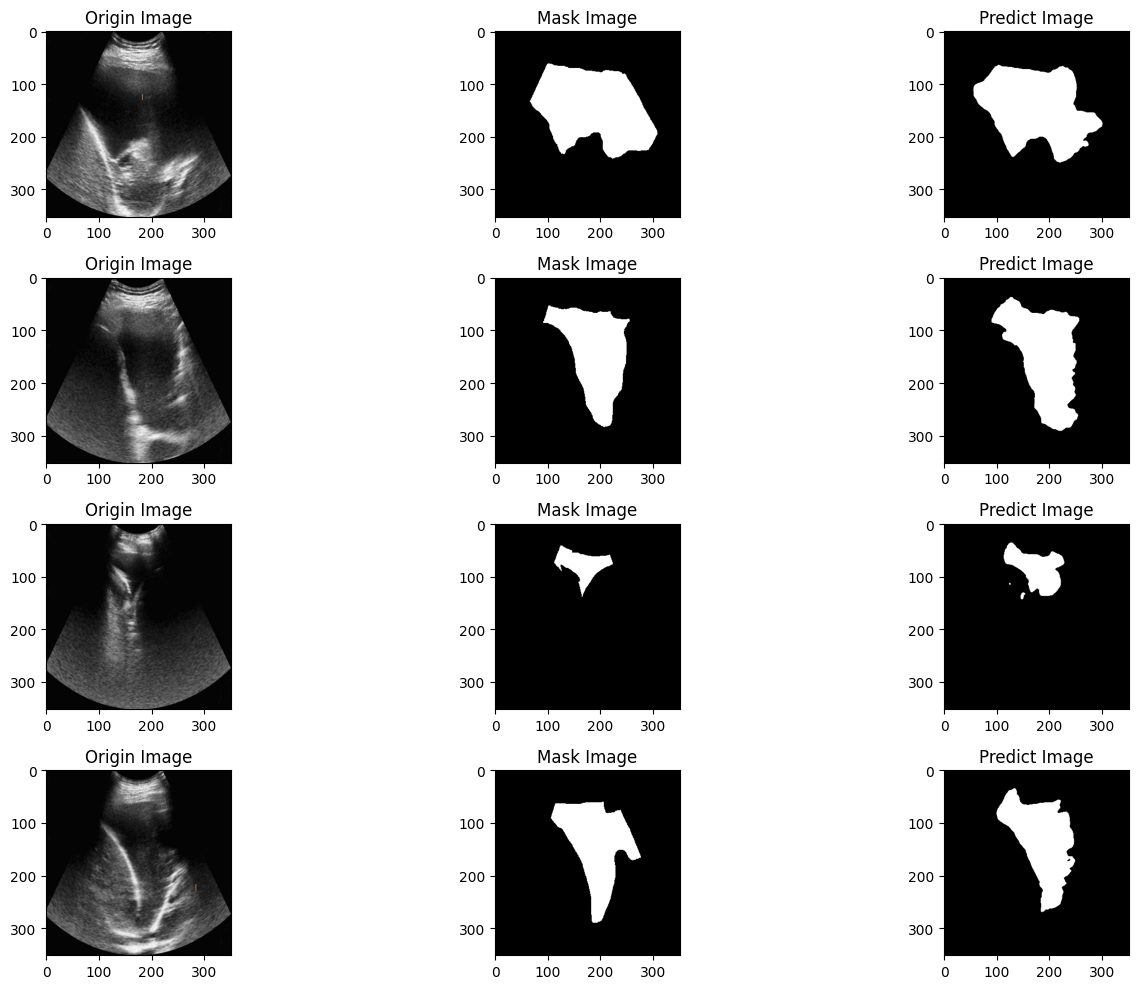

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_UnetPlus_17_kvasir.txt
File done


In [10]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')